In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sc
from scipy import stats

## **Problème 3** : Simuler une loi de distribution a posteriori avec un algorithme MCMC

Considérons une v.a $X$, suivant une loi de Poisson $\mathcal{P}(\theta)$ où $\theta$ est un paramètre inconnu.

Considérons que la loi de distribution _a priori_ de $\theta$ est une loi Gamma de paramètres fixés et connus $k$ et $\lambda$ : $\mathcal{G}(k, \lambda)$ et de distribution :
$
f(x)=\frac{\lambda}{\Gamma(k)}(\lambda(x-\gamma))^{k-1} \exp [-\lambda(x-\gamma)]
$
Ici, le paramètre $\gamma$ est considéré nul, on a donc :
$
f(x)=\frac{\lambda}{\Gamma(k)}(\lambda x)^{k-1}e^{-\lambda x} \\
<=>
f(x)=x^{k-1}\frac{\lambda^k}{\Gamma(k)}e^{-\lambda x}
$

Prenons $x=10$. La loi a posteriori de $\theta | X = x$ est connue, c'est une loi $\mathcal{G}(k + x, \lambda + 1)$

### 1. Utilisation d'un algorithme MCMC

Dans cette question, nous allons générer un échantillon de ette loi en utilisant le produit de la vraissemblance et du prior avec un algorithme MCMC : __Metropolis Hastings__

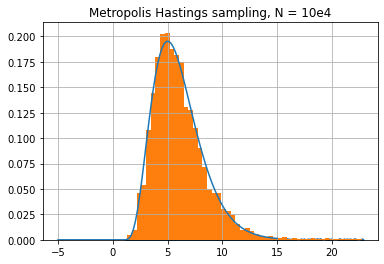

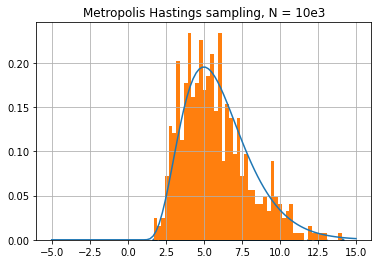

In [65]:
#----------------------------------------------------------------------------------------#
# We know the posterior distribution
k = 5
l = 1

def posterior(x):
    return stats.gamma.pdf(x, k, l)
    return stats.gamma.pdf(x, k + 10, l + 1)

#We want to estimate it and check with the real posterior
def estimated_posterior(x):
    return poisson_likelihood(k, l) * stats.gamma.pdf(x, k, l)

def poisson_likelihood(k, lambd):
    return ((lambd**k) * np.exp(-lambd))/math.factorial(k)
#----------------------------------------------------------------------------------------#
# compute posterior

x_array = np.linspace(-5.0, 15.0, 100)
y_array = np.asarray( [posterior(x) for x in x_array] )

#----------------------------------------------------------------------------------------#
# Metropolis Hastings sampling from the posterior distribution

N = int(10e4)
s = 10

x = 0
p = posterior(x)

samples = []
samples_small = []

for i in range(N):
    xn = x + np.random.normal(size=1)
    pn = estimated_posterior(xn)
    if pn >= p:
        p = pn
        x = xn
    else:
        u = np.random.rand()
        if u < pn/p:
            p = pn
            x = xn
    if i % s == 0 :
        samples.append(x)
        if i < 10000 :
            samples_small.append(x)
        

#On garde que la moitié supérieure des valeurs 
samples = np.array(samples[len(samples)//2::])
samples_small = np.array(samples_small[len(samples_small)//2::])

plt.scatter(samples, np.zeros_like(samples), s=10)

plt.plot(x_array,y_array)
plt.hist(samples, bins=50,density=1)

plt.title('Metropolis Hastings sampling, N = 10e4')
plt.grid()
plt.savefig('metropolis_hastings_1d.png',bbox_inches='tight')
plt.show()
plt.close()


#-------------------- Same with N = 10000
samples_small = np.array(samples_small)

plt.scatter(samples_small, np.zeros_like(samples_small), s=10)

plt.plot(x_array,y_array)
plt.hist(samples_small, bins=50,density=1)

plt.title('Metropolis Hastings sampling, N = 10e3')
plt.grid()
plt.savefig('metropolis_hastings_1d.png',bbox_inches='tight')
plt.show()
plt.close()

On peut voir en orange l'échantillon réalisé avec la méthode Metropolis Hastings et en bleu, superposé, la vraie fonction de densité, a posteriori.
La courbe et l'histogramme se superposent presque parfaitement, on peut constater l'efficacité de ces méthodes MCMC, notamment celle de Metropolis Hastings.

On peut constater que cette méthode n'échanppe pas à la loi des grands nombres, bein au contraire. Le deuxième graphique représente la même courbe en prenant `N = 10000` au lieu de `N = 100000`, et on constate bien que l'échantillon approxime bien moins efficacement la loi.

### 2. Estimation par noyau de la densité

Nous allons maintenant réaliser une approximation à noyau de la densité associée à l'échantillon de la question précédente, et comparer cette densité estimée avec la vraie densité de la loi $\mathcal{G}(k + x, \lambda + 1)$

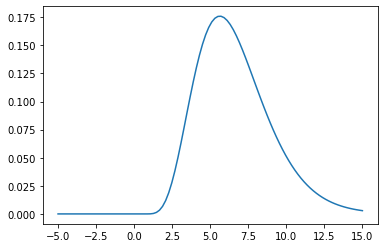

In [63]:
# kernel = stats.poisson_kde(samples)
a,b,c = stats.gamma.fit(samples)

density = stats.gamma.pdf(x, a)

x_array = np.linspace(-5.0, 15.0, 100)
y_array = np.asarray( [stats.gamma.pdf(x, a, b) for x in x_array] )

plt.plot(x_array, y_array)
# plt.plot(kernel(samples))

Sans surprise au vue des résultats de la question 1, nous constatons que les densités sont très semblables. Les outils numériques disponibles permettent aux méthodes MCMC d'être très efficace et de pouvoir approximer un grand nombre de lois. Cela est dû à la possibilité de simuler un grand nombre d'échantillons, et de permettre aux solutions de converger.